In [36]:
import os
import tensorflow as tf
from util import constants
from util.config_util import get_model_params, get_task_params, get_train_params
from tf2_models.trainer import Trainer
from absl import app
from absl import flags
import numpy as np
from util.models import MODELS
from util.tasks import TASKS
from notebook_utils import *
%matplotlib inline
import pandas as pd
import seaborn as sns; sns.set()
from tqdm import tqdm

%matplotlib inline
import pandas as pd
import seaborn as sns; sns.set()
from attention_graph_util import *



In [75]:

task_name = 'sst2'
chkpt_dir='../tf_ckpts'
task_params = get_task_params()
task_params.batch_size =1
task = TASKS[task_name](get_task_params(), data_dir='../data')
cl_token = task.databuilder.sentence_encoder().encode(constants.bos)

tokenizer = task.databuilder.sentence_encoder()._tokenizer

In [39]:
config = {'model_name':'cl_bert',
        'model_config':'small_gpt_v9',
        'learning_rate':0.001,
        'exp_name':'samira_offlineteacher_v1',
        'chkpt_dir': '../tf_ckpts'
}
hparams=get_model_params(task, config['model_name'], config['model_config'])
hparams.output_attentions = True
hparams.output_embeddings = True

model, ckpt = get_model(config, task, hparams, cl_token)


model.evaluate(task.valid_dataset, steps=100)

model config: small_gpt_v9
{'embedding_dim': 128, 'resid_pdrop': 0.4, 'embd_pdrop': 0.2, 'attn_pdrop': 0.6, 'initializer_range': 0.05}
Restored student from ../tf_ckpts/sst2/cl_bert_h-128_d-6_rdrop-0.4_adrop-0.6_indrop-0.2_small_gpt_v9_0.001_samira_offlineteacher_v1/ckpt-85


100/100 [==============================] - 6s 57ms/step - loss: 1.7545 - classification_loss: 1.7119 - sparse_categorical_accuracy: 0.7603: 2s - loss: 1.7465 - classification_loss: 1.7038 - sparse_categor


[1.754535665512085, 1.7118692, 0.7602696]

In [40]:
for examples in  task.valid_dataset:
    break

In [41]:
index = 0
sentence =  task.databuilder.sentence_encoder().decode(examples[index][0])#'<bos> the young girl who plays with the older kids is happy <eos>'
print(sentence)
encoded_sentence = task.databuilder.sentence_encoder().encode(sentence)
outputs = model.detailed_call(np.asarray([encoded_sentence]), training=False)
print("output len: ", len(outputs))
logits = outputs[0]
print((np.argmax(logits)))
logits, last_state, presents, keyvalues, attentions, embeddings = outputs
_attentions = [att.numpy() for att in attentions]
attentions_mat = np.asarray(_attentions)[:,0]
print(attentions_mat.shape)


at its worst , it implodes in a series of very bad special effects . 
output len:  6
0
(6, 8, 19, 19)


In [50]:
splitted_sentence = ['<cls>']+tokenizer.tokenize(sentence)

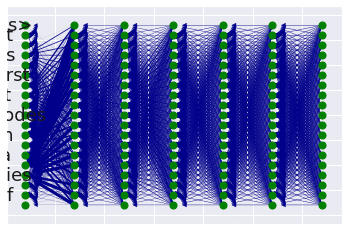

In [48]:
att_mat = attentions_mat.sum(axis=1)
adj_mat, labels_to_index = get_adjmat(mat=att_mat, input_tokens=splitted_sentence)

G = draw_attention_graph(adj_mat,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])

In [46]:
tokenize('this is fun')

['this', ' ', 'is', ' ', 'fun']

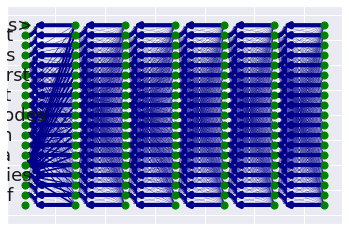

In [51]:
res_att_mat = attentions_mat.sum(axis=1)
res_att_mat = res_att_mat + 8*np.eye(res_att_mat.shape[1])[None,...]
res_att_mat = 8*res_att_mat / res_att_mat.sum(axis=-1)[...,None]
 
res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=splitted_sentence)

res_G = draw_attention_graph(res_adj_mat,res_labels_to_index, n_layers=res_att_mat.shape[0], length=res_att_mat.shape[-1])

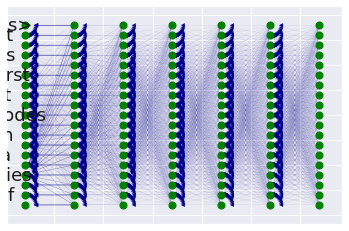

In [52]:
output_nodes = []
input_nodes = []
for key in labels_to_index:
    if 'L6' in key:
        output_nodes.append(key)
    if labels_to_index[key] < attentions_mat.shape[-1]:
        input_nodes.append(key)

flow_values = compute_flows(res_G, res_labels_to_index, input_nodes, length=attentions_mat.shape[-1])
flow_G = draw_attention_graph(flow_values,labels_to_index, n_layers=attentions_mat.shape[0], length=attentions_mat.shape[-1])
#plt.savefig('flow_attentions.png', transparent=True)

In [76]:
sentences = []
all_atts = []
all_main_probs = []
all_index_probs = []
prob_fn = task.get_probs_fn()
count = 0
for x, y in iter(task.valid_dataset):
    max_len = x.shape[1]
    outputs = model.detailed_call(np.asarray([encoded_sentence]), training=False)
    main_logits, last_state, presents, keyvalues, attentions, embeddings = outputs
    _attentions = [att.numpy() for att in attentions]
    attentions = np.transpose(np.asarray(_attentions), (1,0,2,3,4))
    main_probs = prob_fn(main_logits, y, 1)
    batch_indexes = tf.range(len(y), dtype=tf.int64)
    indexes = tf.concat([batch_indexes[:,None], y[:,None]], axis=1)
    correct_main_probs = tf.gather_nd(main_probs, indexes).numpy()

    sentences.append(task.databuilder.sentence_encoder().decode(x[0]))
    all_atts.extend(attentions)
    all_main_probs.extend(correct_main_probs)
    all_index_probs.append([])
    print(count, max_len)
    # This loop can be optimized so that there is only one call...
    new_xz = []
    yz = []
    x_correct_main_probs = []
    for i in np.arange(1,max_len-1):
        batch_size = tf.shape(x)[0]
        unktoken = task.databuilder.sentence_encoder().encode(' ')
        unk = tf.reshape(tf.convert_to_tensor(unktoken, dtype=tf.int64)[None], (-1,1))
        unks = tf.tile(unk, (batch_size, 1))
        new_x = tf.concat([x[:,:i],unks, x[:,i+1:]], axis=-1)
        new_xz.extend(new_x)
        yz.extend(y)
        x_correct_main_probs.extend(correct_main_probs)
    
    new_x = np.asarray(new_xz)
    yz = np.asarray(yz)
    print(yz.shape)
    print(new_x.shape)
    logits = model(new_x, training=False)
    probs = prob_fn(logits, y, 1)
    print(probs.shape)
    batch_indexes = tf.range(len(probs), dtype=tf.int64)
    
    indexes = tf.concat([batch_indexes[:,None], yz[:,None]], axis=1)
    print(indexes.shape)
    correct_probs = tf.gather_nd(probs, indexes).numpy()
    all_index_probs[-1].extend(abs(x_correct_main_probs - correct_probs))
    count += 1
    if count > 10:
        break

0 57
(3520,)
(3520, 57)
(3520, 2)
(3520, 2)
1 54
(3328,)
(3328, 54)
(3328, 2)
(3328, 2)
2 58
(3584,)
(3584, 58)
(3584, 2)
(3584, 2)
3 52
(3200,)
(3200, 52)
(3200, 2)
(3200, 2)
4 56
(3456,)
(3456, 56)
(3456, 2)
(3456, 2)
5 60
(3712,)
(3712, 60)
(3712, 2)
(3712, 2)
6 51
(3136,)
(3136, 51)
(3136, 2)
(3136, 2)
7 48
(2944,)
(2944, 48)
(2944, 2)
(2944, 2)
8 56
(3456,)
(3456, 56)
(3456, 2)
(3456, 2)
9 54
(3328,)
(3328, 54)
(3328, 2)
(3328, 2)
10 58
(3584,)
(3584, 58)
(3584, 2)
(3584, 2)


In [71]:
def spearmanr(x, y):
    """ `x`, `y` --> pd.Series"""
    x = pd.Series(x)
    y = pd.Series(y)
    assert x.shape == y.shape
    rx = x.rank(method='dense')
    ry = y.rank(method='dense')
    d = rx - ry
    dsq = np.sum(np.square(d))
    n = x.shape[0]
    coef = 1. - (6. * dsq) / (n * (n**2 - 1.))
    return coef

def get_raw_att_relevance(full_att_mat, input_tokens, layer=-1):
    cls_index = 0
    return full_att_mat[layer].sum(axis=0)[cls_index]
    

def compute_node_flow(G, labels_to_index, input_nodes, output_nodes,length):
    number_of_nodes = len(labels_to_index)
    flow_values=np.zeros((number_of_nodes,number_of_nodes))
    for key in output_nodes:
        if key not in input_nodes:
            current_layer = int(labels_to_index[key] / length)
            pre_layer = current_layer - 1
            u = labels_to_index[key]
            for inp_node_key in input_nodes:
                v = labels_to_index[inp_node_key]
                flow_value = nx.maximum_flow_value(G,u,v)
                flow_values[u][pre_layer*length+v ] = flow_value
            flow_values[u] /= flow_values[u].sum()
            
    return flow_values

def get_flow_relevance(full_att_mat, input_tokens, layer):
    
    res_att_mat = full_att_mat.sum(axis=1)/8
    res_att_mat = res_att_mat + np.eye(res_att_mat.shape[1])[None,...]
    res_att_mat = res_att_mat / res_att_mat.sum(axis=-1)[...,None]

    res_adj_mat, res_labels_to_index = get_adjmat(mat=res_att_mat, input_tokens=input_tokens)
    
    A = res_adj_mat
    res_G=nx.from_numpy_matrix(A, create_using=nx.DiGraph())
    for i in np.arange(A.shape[0]):
        for j in np.arange(A.shape[1]):
            nx.set_edge_attributes(res_G, {(i,j): A[i,j]}, 'capacity')


    output_nodes = []
    input_nodes = []
    for key in res_labels_to_index:
        if 'L'+str(layer+1) in key:
            output_nodes.append(key)
        if res_labels_to_index[key] < full_att_mat.shape[-1]:
            input_nodes.append(key)
    
    flow_values = compute_node_flow(res_G, res_labels_to_index, input_nodes, output_nodes, length=full_att_mat.shape[-1])
    
    n_layers = full_att_mat.shape[0]
    length = full_att_mat.shape[-1]
    final_layer_attention_raw = flow_values[(layer+1)*length:,layer*length:(layer+1)*length]
    cls_index = 0
    relevance_attention_raw = final_layer_attention_raw[cls_index]

    return relevance_attention_raw
    
    
def get_joint_relevance(full_att_mat, input_tokens, layer):
    att_sum_heads =  full_att_mat.sum(axis=1)/8
    joint_attentions = compute_joint_attention(att_sum_heads, add_residual=True)
    relevance_attentions = joint_attentions[layer][0]
    return relevance_attentions

In [74]:
from tqdm import tqdm
for layer in np.arange(6):
    print("Layer: ", layer) 
#     r_corels, r_pvals = [], []
#     for i in np.arange(len(all_index_probs)):
#         aa = [0, 0]+all_index_probs[i]+[0]
#         bb = get_raw_att_relevance(all_atts[i], ['<cls>']+sentences[i].split(), layer=layer)
#         corel = spearmanr(aa,bb)
#         r_corels.append(corel) 

#     print("r:", np.mean(r_corels), np.std(r_corels))

#     j_corels, j_pvals = [], []
#     for i in np.arange(len(all_index_probs)):
#         aa = [0, 0]+all_index_probs[i]+[0]
#         bb = get_joint_relevance(all_atts[i], ['<cls>']+sentences[i].split(),layer=layer)
#         corel = spearmanr(aa,bb)
#         j_corels.append(corel) 
#     print("j:", np.mean(j_corels), np.std(j_corels))

    f_corels, f_pvals = [], []
    for i in tqdm(np.arange(len(all_index_probs))):
        aa = [0, 0]+all_index_probs[i]+[0]
        bb = get_flow_relevance(all_atts[i], ['<cls>']+tokenizer.tokenize(sentences[i]),layer=layer)
        corel = spearmanr(aa,bb)
        f_corels.append(corel) 
    print("f:", np.mean(f_corels), np.std(f_corels))

  0%|          | 0/11 [00:00<?, ?it/s]

Layer:  0


  0%|          | 0/11 [00:03<?, ?it/s]


AttributeError: 'list' object has no attribute 'shape'